In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
from matplotlib import cm

from sklearn.datasets import make_blobs
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu, softmax, linear, sigmoid
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

tf.autograph.set_verbosity(0)
tf.keras.backend.set_floatx("float64")

tf.get_logger().setLevel("ERROR")

In [3]:
#generate the data set
def gen_data(m, seed=1, sd=0.7):
    """ generate a data set based on a x^2 with added noise """
    X = np.linspace(0, 49, m)
    np.random.seed(seed)
    b = 0
    y_ideal = X**2 + b
    y_noise = y_ideal + sd * y_ideal * (np.random.sample((m,)) - 0.5)
    x_ideal = X
    return X, y_noise, x_ideal, y_ideal

X, y, x_ideal, y_ideal = gen_data(18, 2, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)
print(y_ideal[:5])
print(y[:5])

X.shape (18,) y.shape (18,)
[  0.           8.30795848  33.23183391  74.7716263  132.92733564]
[  0.           5.55094885  34.38709656  71.38639138 125.51762851]


##### Explanation of data generation with  noise 
       Usually we add noise data to the target to represent that we are simulating the true data which usually contains noise.
       
       To Generate random noise and add it to the target, we usually follow:

      - Choose a random distribution to generate noise. 
            Common distributions include Gaussian (normal) distribution, uniform distribution, etc.The choice of distribution depends on the characteristics of the noise you want to simulate. For example, if you expect the noise to be normally distributed around zero, use the Gaussian distribution.
        
      - Determine the noise magnitude
            Decide the standard deviation or range of the noise you want to add. This value controls the intensity of the noise added to the data. A larger value means more significant noise, while a smaller value means less noise.
       
      - Add noise to the target variable:
            For each target value in your regression dataset, generate random noise using the chosen distribution and magnitude determined earlier.Add this noise to the corresponding target value. This will introduce randomness to your target variable.
       
       In the gen_data(), the type of noise being added to the data is relative multiplicative noise. The noise is scaled based on the magnitude specified by the scale/sd parameter, and it is applied to the ideal target values, which are generated based on the function y_ideal = x_train^2 + c. 
   
       Here's a breakdown of the noise generation process:

    First, an ideal target array y_ideal is calculated based on the equation y_ideal = x_train^2 + c, where x_train is the input feature array (generated with np.linspace) and c is set to 0 in this case.

    Next, random relative multiplicative noise is added to the y_ideal array. The noise is generated using the np.random.sample function, which generates random numbers uniformly between 0 and m. The noise is then scaled by scale/sd, and its sign is randomized (by subtracting 0.5) before being added to the ideal target values.

    This type of noise generation is useful when you want to simulate the variability of the data in a multiplicative manner, where the noise scales proportionally to the magnitude of the ideal target values. The noise has both positive and negative components, and its magnitude is controlled by the scale parameter.

    It's worth noting that the noise is multiplicative here because it's applied as a percentage of the ideal target value. If you add a constant value to the target (e.g., Gaussian noise with a fixed standard deviation), that would be an additive noise instead.

    To summarize, the noise being added in this function is relative multiplicative noise, and the function generates a dataset based on the quadratic relationship y = x^2 with this noise added to the ideal target values.

### Evaluating a Learning Algorithm (Polynomial Regression)
    Let's say you have created a machine learning model and you find it fits your training data very well. You're done? Not quite. The goal of creating the model was to be able to predict values for new examples(good eneralization)

    How can you test your model's performance on new data before deploying it?
   
    The answer has two parts:

            Split your original data set into "Training" and "Test" sets.
            Use the training data to fit the parameters of the model
            Use the test data to evaluate the model on new data
            Develop an error function to evaluate your model.

##### 2.1 Splitting your data set
       Lectures advised reserving 20-40% of your data set for testing. Let's use an sklearn function train_test_split to perform the split. Double-check the shapes after running the following cell.

In [4]:
#split the data using sklearn routine 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X_train.shape (12,) y_train.shape (12,)
X_test.shape (6,) y_test.shape (6,)


##### 2.1.1 Plot Train, Test sets
    You can see below the data points that will be part of training (in red) are intermixed with those that the model is not trained on (test). This particular data set is a quadratic function with noise added. The "ideal" curve is shown for reference.

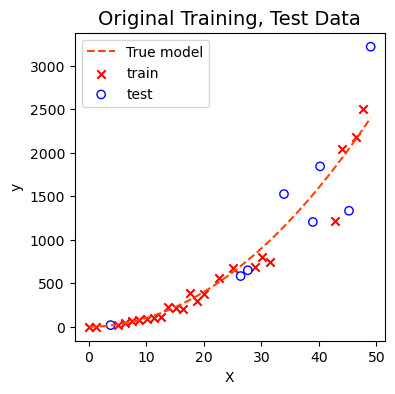

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(x_ideal, y_ideal, label="True model", linestyle="--", c="orangered")
ax.scatter(X_train, y_train, marker="x", c="r", label="train")
ax.scatter(X_test, y_test, marker="o", facecolor="none", edgecolors="blue", label="test")
ax.set_xlabel("X")
ax.set_ylabel("y")
ax.set_title("Original Training, Test Data",fontsize = 14)
ax.legend()
plt.show()

##### 2.2 Error calculation for model evaluation, linear regression
    When evaluating a linear regression model, you average the squared error difference of the predicted values and the target values.

##### Exercise 1
    Below, create a function to evaluate the error on a data set for a linear regression model.

In [ ]:
def eval_mse(y, yhat):
    m = len(y)
    error = (yhat - y) ** 2
    mse = np.sum(error) / (2 * m)
    return mse

##### 2.3 Compare performance on training and test data
    Let's build a high degree polynomial model to minimize training error. This will use the linear_regression functions from sklearn. 
    Steps:
    ------
        - create and fit the model. ('fit' is another name for training or running gradient descent).
        - compute the error on the training data.
        - compute the error on the test data.

In [6]:
class lin_model:
    def __init__(self, degree, regularize=False, lambda_=None):
        self.degree = degree
        self.regularize = regularize
        if regularize:
            self.lambda_ = lambda_
            self.model = Ridge(alpha=lambda_)
        else:
            self.model = LinearRegression()
        self.poly = PolynomialFeatures(degree=degree, include_bias=False)
        self.scaler = StandardScaler()
    
    def fit(self, X_train, y_train):
        X_train_mapped = self.poly.fit_transform(X_train.reshape(-1, 1)) #expects 2D array
        X_train_mapped_scaled = self.scaler.fit_transform(X_train_mapped)
        self.model.fit(X_train_mapped_scaled, y_train)
        
    def predict(self, X):
        X_mapped = self.poly.transform(X.reshape(-1, 1))
        X_mapped_scaled = self.scaler.transform(X_mapped)
        y_preds = self.model.predict(X_mapped_scaled)
        return(y_preds)
    
    def evaluate(self, y, y_preds):
        error = mean_squared_error(y, y_preds) / 2
        return(error)

degree = 10
model = lin_model(degree)
model.fit(X_train, y_train)
y_train_preds = model.predict(X_train)
J_train = model.evaluate(y_train, y_train_preds)

y_test_preds = model.predict(X_test)
J_test = model.evaluate(y_test, y_test_preds)

print(f"training err {J_train:0.2f}, test err {J_test:0.2f}")

#The computed error on the training set is substantially less than that of the test set. Looks like model is overfitting
#the highest degree also explains it

training err 58.01, test err 171215.01


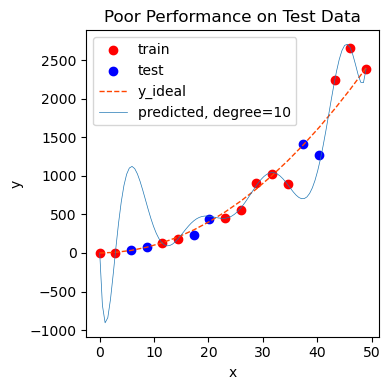

In [7]:
#plotting the train and test data and the model prediction
def plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, degree):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    
    ax.scatter(X_train, y_train, c="r", label="train")
    ax.scatter(X_test, y_test, c="b", label="test")
    ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
    ax.plot(x, y_pred, lw=0.5, label=f"predicted, degree={degree}") #model predictions
    
    ax.set_title("Poor Performance on Test Data",fontsize = 12)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_ylim())
    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

# plot predictions over data range
x = np.linspace(0, int(X.max()), 100) # generating data within range of total X
#Imagine like new data. and we predict values for those to plot predictions
y_pred = model.predict(x)

plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, degree)

    The above plot shows why this is the case. The model fits the training data very well. To do so, it has created a complex function(Degree 10). The test data was not part of the training and the model does a poor job of predicting on this data.
    
    This model would be described as 1) is overfitting, 2) has high variance 3) 'generalizes' poorly.
    
    The test set error shows this model will not work well on new data. If you use the test error to guide improvements in the model, then the model will perform well on the test data... but the test data was meant to represent new data. You need yet another set of data to test new data performance.

    The proposal made during lecture is to separate data into three groups. The distribution of training, cross-validation and test sets shown in the below table is a typical distribution, but can be varied depending on the amount of data available.

      -------------------------------------------------------------------------------------------------------------     
       data	            |    % of total	|            Description
      -------------------------------------------------------------------------------------------------------------
          training	    |        60	        |     Data used to tune model parameters w and b in training or fitting
        cross-validation|	     20	        |      Data used to tune other model parameters like degree of polynomial,
                        |                   |      regularization, learning rate or the architecture of a neural network.
          test	    |        20	        |      Data used to test the model after tuning to gauge performance on new data
          
    Let's generate three data sets below. We'll once again use train_test_split from sklearn but will call it twice to get three splits:

In [14]:
# Generate  data
X, y, x_ideal, y_ideal = gen_data(40, 5, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.40, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.50, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_val.shape", X_val.shape, "y_val.shape", y_val.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (40,) y.shape (40,)
X_train.shape (24,) y_train.shape (24,)
X_val.shape (8,) y_val.shape (8,)
X_test.shape (8,) y_test.shape (8,)


#### 3 - Bias and Variance
    Above, it was clear the degree of the polynomial model was too high. How can you choose a good value for the degree of polynomial? 
    
    The training and cross-validation performance can provide guidance. By trying a range of degree values, the training and cross-validation performance can be evaluated. As the degree becomes too large, the cross-validation performance will start to degrade relative to the training performance. Let's try this on our example.

##### 3.1 Plot Train, Cross-Validation, Test
    You can see below the datapoints that will be part of training (in red) are intermixed with those that the model is not trained on (test and cv).

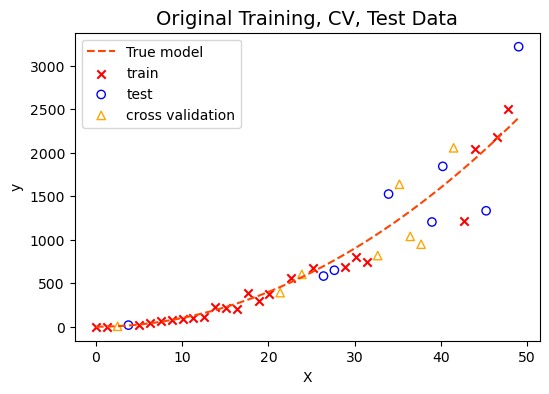

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(x_ideal, y_ideal, label="True model", linestyle="--", c="orangered")
ax.scatter(X_train, y_train, marker="x", c="r", label="train")
ax.scatter(X_test, y_test, marker="o", facecolor="none", edgecolors="blue", label="test")
ax.scatter(X_val, y_val, marker="^", facecolor="none", edgecolors="orange", label="cross validation")
ax.set_xlabel("X")
ax.set_ylabel("y")
ax.set_title("Original Training, CV, Test Data",fontsize = 14)
ax.legend()
plt.show()

#### 3.2 Finding the optimal degree
    In previous labs, you found that you could create a model capable of fitting complex curves by utilizing a polynomial features (See Course1, Week2 Feature Engineering and Polynomial Regression Lab). Further, you demonstrated that by increasing the degree of the polynomial, you could create overfitting. (See Course 1, Week3, Over-Fitting Lab). Let's use that knowledge here to test our ability to tell the difference between over-fitting and under-fitting.

    Let's train the model repeatedly, increasing the degree of the polynomial each iteration. Here, we're going to use the scikit-learn linear regression model for speed and simplicity.

In [16]:
#finding optimal degree
max_degree = 9
train_mses = np.zeros(max_degree)
val_mses = np.zeros(max_degree)
x = np.linspace(0, int(X.max()), 100)
y_preds = np.zeros((100, max_degree))  #for each degree we gonna get the preds i,e each degree as column for y_preds
print(y_preds.shape) #(100, 9)

for degree in range(max_degree):
    linear_reg_model = lin_model(degree+1)
    linear_reg_model.fit(X_train, y_train)
    y_train_preds = linear_reg_model.predict(X_train)
    y_val_preds = linear_reg_model.predict(X_val)
    train_mse = linear_reg_model.evaluate(y_train, y_train_preds)
    train_mses[degree] = train_mse
    val_mse = linear_reg_model.evaluate(y_val, y_val_preds)
    val_mses[degree] = val_mse
    y_preds[:, degree] = linear_reg_model.predict(x)
    
print(y_preds[:2])
optimal_degree = np.argmin(val_mses) + 1
print(optimal_degree)

(100, 9)
[[-3.80756225e+02  5.34544323e+01 -7.28896989e+01  5.30455497e+01
   4.41454466e+00 -2.79159963e+01  2.44997740e+01 -6.03689698e-01
  -1.11850202e+01]
 [-3.57455694e+02  4.97809442e+01 -5.98109165e+01  3.28749422e+01
   6.28837152e+00 -2.78481979e-02 -8.54984258e+00  1.84984911e+00
   1.00887025e+01]]
2


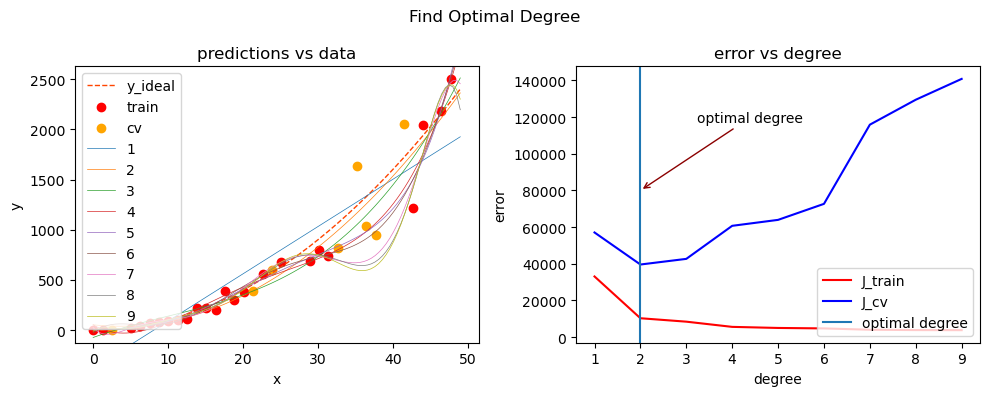

In [19]:
#Plot the results
def plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal, 
                   err_train, err_cv, optimal_degree, max_degree):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    
    ax[0].plot(x_ideal, y_ideal, "--", color="orangered", label="y_ideal", lw=1)
    ax[0].scatter(X_train, y_train, color="red", label="train")
    ax[0].scatter(X_cv, y_cv, color="orange", label="cv")
    ax[0].set_xlim(ax[0].get_xlim())
    ax[0].set_ylim(ax[0].get_ylim())
    ax[0].set_title("predictions vs data",fontsize = 12)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")
    
    #plotting the models predictions of each degree on the same plot
    for i in range(0, max_degree):
        ax[0].plot(x, y_pred[:, i],  lw=0.5, label=f"{i+1}")
    ax[0].legend(loc="upper left")

    ax[1].set_title("error vs degree",fontsize = 12)
    degrees = list(range(1, max_degree+1))
    ax[1].plot(degrees, err_train[0:], c="r", label="J_train")
    ax[1].plot(degrees, err_cv[0:], c="b", label="J_cv")
    ax[1].axvline(optimal_degree, label="optimal degree")
    ax[1].set_ylim(*ax[1].get_ylim())
    ax[1].annotate("optimal degree", xy=(optimal_degree, 80000), xycoords="data",
                  xytext=(0.3, 0.8), textcoords="axes fraction", fontsize=10,
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3",
                                color="darkred", lw=1))
    ax[1].set_xlabel("degree")
    ax[1].set_ylabel("error")
    ax[1].legend(loc="lower right")
    fig.suptitle("Find Optimal Degree",fontsize = 12)
    plt.tight_layout()
    plt.show()

plt.close("all")
plt_optimal_degree(X_train, y_train, X_val, y_val, x, y_preds, x_ideal, y_ideal, 
                   train_mses, val_mses, optimal_degree, max_degree)

    The plot above demonstrates that separating data into two groups, i.e data the model is trained on and, data the model has not been trained on, can be used to determine if the model is underfitting or overfitting. 
    
    In our example, we created a variety of models varying from underfitting to overfitting by increasing the degree of the polynomial used.

    On the left plot, the solid lines represent the predictions from these models. A polynomial model with degree 1 produces a straight line that intersects very few data points, while the maximum degree hews very closely to every data point.

    On the right, the error on the trained data (red) decreases as the model complexity increases as expected. The error of the cross-validation data decreases initially as the model starts to conform to the data, but then increases as the model starts to over-fit on the training data (fails to generalize).
    
    It's worth noting that the curves in these examples as not as smooth as one might draw for a lecture. It's clear the specific data points assigned to each group can change your results significantly. The general trend is what is important.

#### 3.3 Tuning Regularization.
    In previous labs, you have utilized regularization to reduce overfitting. Similar to degree, one can use the same methodology to tune the regularization parameter lambda.

    Let's demonstrate this by starting with a high degree polynomial and varying the regularization parameter. Note we are using the same ridge regression model with regularization parameter of scikit and with polynomial features of high degree say 10

In [21]:
lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100])
num_steps = len(lambda_range)
degree = 10 #considering complex model to show the effect of regularization
train_mses = np.zeros(num_steps)    
val_mses = np.zeros(num_steps)       
x = np.linspace(0, int(X.max()), 100) 
y_preds = np.zeros((100, num_steps))  #columns are lines to plot

for i in range(num_steps):
    lambda_= lambda_range[i]
    linear_model = lin_model(degree, regularize=True, lambda_=lambda_)
    linear_model.fit(X_train, y_train)
    y_train_preds = linear_model.predict(X_train)
    train_mses[i] = linear_model.evaluate(y_train, y_train_preds)
    y_val_preds = linear_model.predict(X_val)
    val_mses[i] = linear_model.evaluate(y_val, y_val_preds)
    y_preds[:, i] = linear_model.predict(x)
    
optimal_reg_idx = np.argmin(val_mses)

-13370.038166781034 347778.1965585186


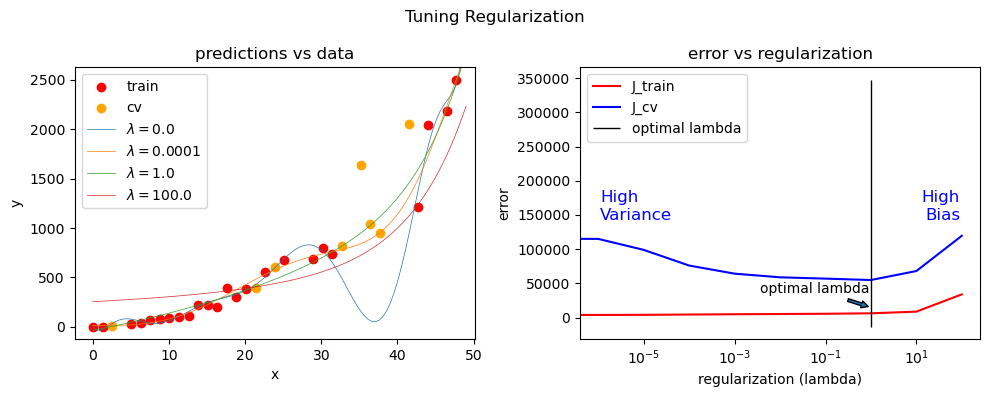

In [22]:
#plotting
def plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    
    ax[0].scatter(X_train, y_train, color="red", label="train")
    ax[0].scatter(X_cv, y_cv, color="orange", label="cv")
    ax[0].set_xlim(ax[0].get_xlim())
    ax[0].set_ylim(ax[0].get_ylim())
    ax[0].set_title("predictions vs data",fontsize = 12)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")
    #plotting the models/ models predictions of some lambda's
    for i in (0, 3, 7, 9):
        ax[0].plot(x, y_pred[:, i],  lw=0.5, label=f"$\lambda={lambda_range[i]}$")
    ax[0].legend(loc="upper left")

    ax[1].set_title("error vs regularization",fontsize = 12)
    degrees = list(range(1, max_degree+1))
    ax[1].plot(lambda_range, err_train[:], c="r", label="J_train")
    ax[1].plot(lambda_range, err_cv[:], c="b", label="J_cv")
    print(*ax[1].get_ylim())
    ax[1].vlines(lambda_range[optimal_reg_idx], *ax[1].get_ylim(), label="optimal lambda", color="black", lw=1)
    ax[1].set_ylim(*ax[1].get_ylim())
    ax[1].annotate("optimal lambda", xy=(lambda_range[optimal_reg_idx], 15000), xycoords="data",
                  xytext=(-80, 10), textcoords="offset points", fontsize=10,
                 arrowprops={"arrowstyle" : "simple"})
    ax[1].set_xscale("log")
    ax[1].set_xlabel("regularization (lambda)")
    ax[1].set_ylabel("error")
    ax[1].text(0.05, 0.44, "High\nVariance", fontsize=12, ha='left', transform=ax[1].transAxes, color="blue")
    ax[1].text(0.95, 0.44, "High\nBias", fontsize=12, ha='right', transform=ax[1].transAxes, color="blue")
    ax[1].legend(loc="upper left")
    fig.suptitle("Tuning Regularization",fontsize = 12)
    plt.tight_layout()
    plt.show()

plt.close("all")
plt_tune_regularization(X_train, y_train, X_val, y_val, x, y_preds, train_mses, val_mses, optimal_reg_idx, lambda_range)

    Above, the plots show that as regularization increases, the model moves from a high variance (overfitting) model to a high bias (underfitting) model. The vertical line in the right plot shows the optimal value of lambda which is 10^0 = 1.Note tha x scale is on log. In this example, the polynomial degree was set to 10.

#### 3.4 Getting more data: Increasing Training Set Size (m) to fix overfitting
    When a model is overfitting (high variance), collecting additional data can improve performance. Let's try that here.

In [23]:
#Add more data
def tune_m():
    """ tune the number of examples to reduce overfitting """
    m = 50
    m_range = np.array(m * np.arange(1, 16))
#     print(m_range.shape) #(15,)
#     print(m_range) #[ 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750]
    num_steps = m_range.shape[0] #15
    train_mses = np.zeros(num_steps)
    val_mses = np.zeros(num_steps)
    y_preds = np.zeros((100, num_steps))
    degree = 16
        
    for i in range(num_steps):
        X, y, x_ideal, y_ideal = gen_data(m=m_range[i], seed=5, sd=0.7)
       
        x_train, x_, y_train, y_ = train_test_split(X, y, test_size=0.40, random_state=1)
        x_val, x_test, y_val, y_test = train_test_split(x_, y_, test_size=0.50, random_state=1)
        
        model = lin_model(degree)
        model.fit(x_train, y_train)
        y_train_preds = model.predict(x_train)
        train_mses[i] = model.evaluate(y_train, y_train_preds)
        y_val_preds = model.predict(x_val)
        val_mses[i] = model.evaluate(y_val, y_val_preds)
        #for predictions
        x = np.linspace(0, int(X.max()), 100)
        y_preds[:, i] = model.predict(x)
     
    return(x_train, y_train, x_val, y_val, x, y_preds, train_mses, val_mses, m_range, degree)

X_train, y_train, X_val, y_val, x, y_preds, train_mses, val_mses, m_range, degree = tune_m()

In [25]:
print(y_preds.shape)
print(X_train.shape)
print(X_val.shape)

(100, 15)
(450,)
(150,)


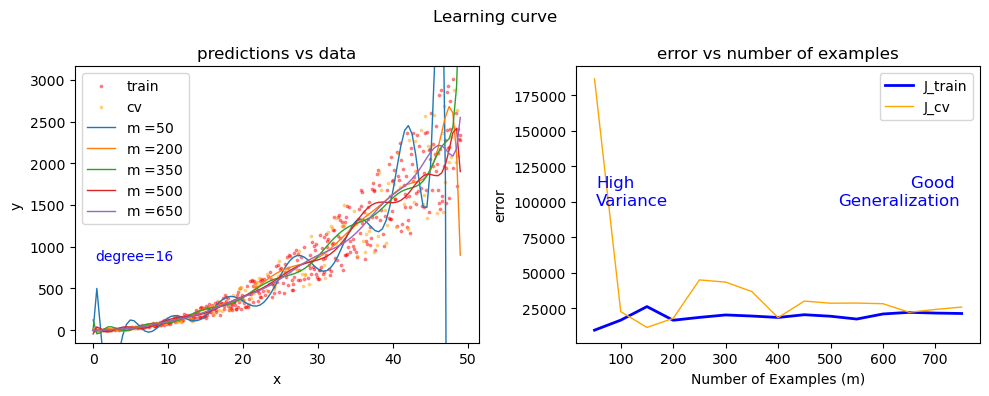

In [29]:
def plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    
    ax[0].scatter(X_train, y_train, color="red", label="train", s=3, alpha=0.4)
    ax[0].scatter(X_cv, y_cv, color="orange", label="cv", s=3, alpha=0.4)
    ax[0].set_xlim(ax[0].get_xlim())
    ax[0].set_ylim(ax[0].get_ylim())
    ax[0].set_title("predictions vs data",fontsize = 12)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")
    #plotting the models for each set of training examples
    for i in range(0, len(m_range), 3):
#         print(i)
        ax[0].plot(x, y_pred[:, i],  lw=1, label=f"m =${m_range[i]}$")
    ax[0].legend(loc="upper left")
    ax[0].text(0.05, 0.3, f"degree={degree}", fontsize=10, ha='left', transform=ax[0].transAxes,color = "blue")


    ax[1].set_title("error vs number of examples",fontsize = 12)
    ax[1].plot(m_range, err_train[:], c="blue", label="J_train", lw=2)
    ax[1].plot(m_range, err_cv[:], c="orange", label="J_cv", lw=1)
    ax[1].set_xlabel("Number of Examples (m)")
    ax[1].set_ylabel("error")
    fig.suptitle("Learning curve",fontsize = 12)
    ax[1].text(0.05, 0.5, "High\nVariance", fontsize=12, ha='left', transform=ax[1].transAxes, color = "blue")
    ax[1].text(0.95, 0.5, "Good \nGeneralization", fontsize=12, ha='right', transform=ax[1].transAxes, color = "blue")
    ax[1].legend()
    plt.tight_layout()
    plt.show()  

plt_tune_m(X_train, y_train, X_val, y_val, x, y_preds, train_mses, val_mses, m_range, degree)

    The above plots show that when a model has high variance and is overfitting, adding more examples improves performance. Note the curves on the left plot. The final curve with the highest value of m is a smooth curve that is in the center of the data. On the right, as the number of examples increases, the performance of the training set and cross-validation set converge to similar values. Note that the curves are not as smooth as one might see in a lecture. That is to be expected. The trend remains clear: more data improves generalization.

    Note that adding more examples when the model has high bias (underfitting) does not improve performance.

#### 4 - Evaluating a Learning Algorithm (Neural Network)
    Above, you tuned aspects of a polynomial regression model. Here, you will work with a neural network model. Let's start by creating a classification data set.

##### 4.1 Data Set
    Run the cell below to generate a data set and split it into training, cross-validation (CV) and test sets. In this example, we're increasing the percentage of cross-validation data points for emphasis.

In [2]:
# Generate classification data set using make_blobs
def gen_blobs():
    classes = 6
    m = 800
    std = 0.4
    centers = np.array([[-1, 0], [1, 0], [0, 1], [0, -1], [-2,1],[-2,-1]])
    X, y = make_blobs(n_samples=m, centers=centers, cluster_std=std, random_state=2, n_features=2)
    return(X, y, centers, classes, std)

X, y, centers, classes, std = gen_blobs()

In [3]:
# split the data. Large CV population for demonstration
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.50, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.20, random_state=1)
print("X_train.shape:", X_train.shape, "X_cv.shape:", X_cv.shape, "X_test.shape:", X_test.shape)

X_train.shape: (400, 2) X_cv.shape: (320, 2) X_test.shape: (80, 2)


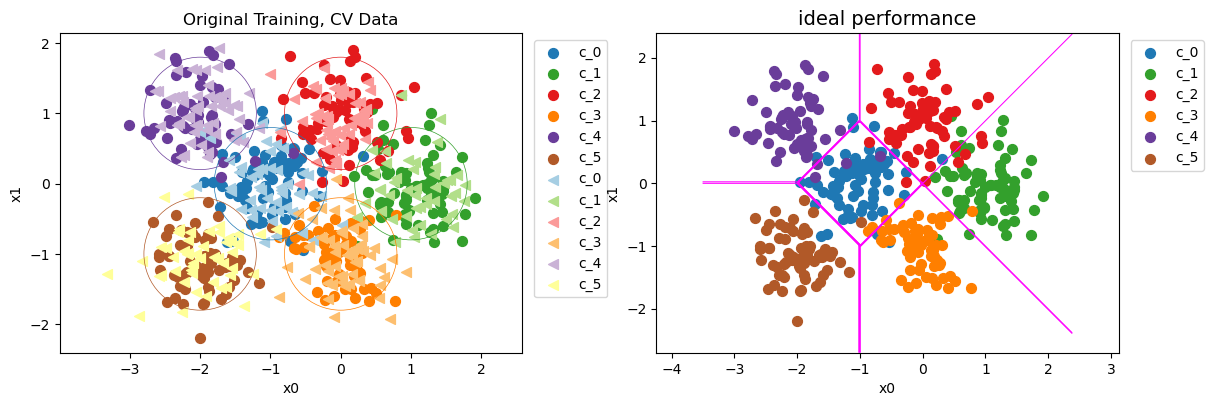

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl

dkcolors = plt.cm.Paired((1, 3, 5, 7, 9, 11))
ltcolors = plt.cm.Paired((0, 2, 4, 6, 8, 10))
dkcolors_map = mpl.colors.ListedColormap(dkcolors)
ltcolors_map = mpl.colors.ListedColormap(ltcolors)

#Plot a multi-class categorical decision boundary
def plot_cat_decision_boundary(ax, X, predict, class_labels=None, legend=False, vector=True, color='g', lw = 1):
    # create a mesh to points to plot
    pad = 0.5
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad
    h = max(x_max-x_min, y_max-y_min) / 200
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    points = np.c_[xx.ravel(), yy.ravel()]
    
    #make predictions for each point in mesh
    if vector:
        Z = predict(points)
    else:
        Z = np.zeros((len(points),))
        for i in range(len(points)):
            Z[i] = predict(points[i].reshape(1, 2))
    Z = Z.reshape(xx.shape)

    #contour plot highlights boundaries between values - classes in this case
    ax.contour(xx, yy, Z, colors=color, linewidths=lw) 
    ax.axis('tight')

def recat(point, origins):
    """ categorize a point based on distance from origin of clusters """
    nclusters = len(origins)
    min_dist = 10000
    y_new = None
    for j in range(nclusters):
        #calculatin euclidean distance
        temp = origins[j] - point.reshape(2,)
        dist = np.sqrt(np.dot(temp.T, temp)) #dot product of a vector with itself is equivalent to summing the squares of its elements.
        if dist < min_dist:
            y_new = j
            min_dist = dist
    return(y_new)

def plt_mc_data(ax, X, y, classes, class_labels=None, map=plt.cm.Paired, legend=False, size=50, marker="o"):
    normy = mpl.colors.Normalize(vmin=0, vmax=classes)
    for i in range(classes):
        idx = np.where(y == i)
        label = class_labels[i] if class_labels else f"c_{i}"
        ax.scatter(X[idx, 0], X[idx, 1],
                  s=size, marker=marker,
                   color=map(normy(i)), label=label)
    if legend: ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.0))
    ax.axis("equal")

def plt_train_eq_dist(X_train, y_train, classes, X_cv, y_cv, centers, std):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    #plot the original training data and the cross validation data
    plt_mc_data(ax[0], X_train, y_train, classes, map=dkcolors_map, legend=True)
    plt_mc_data(ax[0], X_cv, y_cv, classes, map=ltcolors_map, marker="<", legend=True)
    
    #draw a circle around each class
    classes_1 = np.unique(y_train)
    for c in classes_1:
        circle = plt.Circle(centers[c], 2*std, color=dkcolors_map(c), fill=False, lw=0.5, clip_on=False)
        ax[0].add_patch(circle)
    ax[0].set_title("Original Training, CV Data")
    ax[0].set_xlabel('x0') ; ax[0].set_ylabel("x1");
        
    #create a model and categorize the points and plot decision boundary after categorizing
    cat_predict = lambda point: recat(point.reshape(1,2), centers) #ideal model, see we are passing centers here
    plot_cat_decision_boundary(ax[1], X_train, cat_predict, vector=False, color="magenta", lw=0.75)
    ax[1].set_title("ideal performance", fontsize=14)
    
    #add the original data to the decison boundary
    plt_mc_data(ax[1], X_train,y_train, classes, map=dkcolors_map, legend=True, size=50)
    ax[1].set_xlabel('x0') ; ax[1].set_ylabel("x1");
    plt.tight_layout(pad=0.5)
    plt.show()
    
plt_train_eq_dist(X_train, y_train, classes, X_cv, y_cv, centers, std)

    Above, you can see the data on the left. There are six clusters identified by color. Both training points (dots) and cross-validataion points (triangles) are shown. The interesting points are those that fall in ambiguous locations where either cluster might consider them members. What would you expect a neural network model to do? What would be an example of overfitting? underfitting?
    On the right is an example of an 'ideal' model, or a model one might create knowing the source of the data. The lines represent 'equal distance' boundaries where the distance between center points is equal. It's worth noting that this model would "misclassify" roughly 8% of the total data set.
    
#### 4.2 Evaluating categorical model by calculating classification error
    The evaluation function for categorical models used here is simply the fraction of incorrect predictions:
                         Jcv = 1/m Σ {1 if yhat != y
                                     {0 otherwise
                                     
#### Exercise 2
    Below, complete the routine to calculate classification error. Note, in this lab, target values are the index of the category and are not one-hot encoded.                          

In [5]:
def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)             
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
        if yhat[i] != y[i]:
            incorrect +=1
    cerr = incorrect / m
    
    return(cerr)

#### 5 - Model Complexity
    Below, you will build two models. A complex model and a simple model. You will evaluate the models to determine if they are likely to overfit or underfit.

##### 5.1 Complex model

###### Exercise 3
    Below, compose a three-layer model:

    Dense layer with 120 units, relu activation
    Dense layer with 40 units, relu activation
    Dense layer with 6 units and a linear activation (not softmax)
    Compile using

    loss with SparseCategoricalCrossentropy, remember to use from_logits=True
    Adam optimizer with learning rate of 0.01.

In [37]:
#complex neural network
tf.random.set_seed(1234)
model_c = Sequential([
    Dense(120, activation="relu"),
    Dense(40, activation="relu"),
    Dense(classes, activation="linear")
], name="complex")
model_c.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer=Adam(learning_rate=0.01))

In [38]:
#training
model_c.fit(X_train, y_train, epochs=1000)

Epoch 1/1000
13/13 [==============================] - 1s 2ms/step - loss: 1.0150
Epoch 2/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4158
Epoch 3/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3319
Epoch 4/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2884
Epoch 5/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2679
Epoch 6/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2993
Epoch 7/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2570
Epoch 8/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2253
Epoch 9/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2242
Epoch 10/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2081
Epoch 11/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2251
Epoch 12/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2090
Epoch 13/1000
13/13 [====

Epoch 101/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2078
Epoch 102/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1892
Epoch 103/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2032
Epoch 104/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1664
Epoch 105/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1529
Epoch 106/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1486
Epoch 107/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1582
Epoch 108/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1470
Epoch 109/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1588
Epoch 110/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1431
Epoch 111/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1551
Epoch 112/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1592
Epoc

13/13 [==============================] - 0s 2ms/step - loss: 0.1067
Epoch 200/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1121
Epoch 201/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1027
Epoch 202/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1059
Epoch 203/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0987
Epoch 204/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1099
Epoch 205/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1105
Epoch 206/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1180
Epoch 207/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1507
Epoch 208/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1293
Epoch 209/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1250
Epoch 210/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1017
Epoch 211/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0947
Epoch 298/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0893
Epoch 299/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0744
Epoch 300/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0830
Epoch 301/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0914
Epoch 302/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1019
Epoch 303/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1022
Epoch 304/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0677
Epoch 305/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0793
Epoch 306/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0713
Epoch 307/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0829
Epoch 308/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0698
Epoch 309/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.1100
Epoch 396/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1075
Epoch 397/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0933
Epoch 398/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0893
Epoch 399/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0859
Epoch 400/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0968
Epoch 401/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0977
Epoch 402/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0739
Epoch 403/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0733
Epoch 404/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0651
Epoch 405/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0613
Epoch 406/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0576
Epoch 407/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0385
Epoch 494/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0407
Epoch 495/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0419
Epoch 496/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0350
Epoch 497/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0365
Epoch 498/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0370
Epoch 499/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0345
Epoch 500/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0297
Epoch 501/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0325
Epoch 502/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0372
Epoch 503/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0417
Epoch 504/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0422
Epoch 505/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0348
Epoch 592/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0507
Epoch 593/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1160
Epoch 594/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1522
Epoch 595/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1863
Epoch 596/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1864
Epoch 597/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1390
Epoch 598/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1212
Epoch 599/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0957
Epoch 600/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1046
Epoch 601/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0709
Epoch 602/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0741
Epoch 603/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0462
Epoch 690/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0451
Epoch 691/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0479
Epoch 692/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0409
Epoch 693/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0652
Epoch 694/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0448
Epoch 695/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0464
Epoch 696/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0395
Epoch 697/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0444
Epoch 698/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0404
Epoch 699/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0371
Epoch 700/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0358
Epoch 701/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0429
Epoch 788/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0405
Epoch 789/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0375
Epoch 790/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0436
Epoch 791/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0429
Epoch 792/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0518
Epoch 793/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0446
Epoch 794/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0423
Epoch 795/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0355
Epoch 796/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0359
Epoch 797/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0460
Epoch 798/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0403
Epoch 799/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.1029
Epoch 886/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1002
Epoch 887/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0703
Epoch 888/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0617
Epoch 889/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0597
Epoch 890/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0523
Epoch 891/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0526
Epoch 892/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0652
Epoch 893/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0746
Epoch 894/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0514
Epoch 895/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0510
Epoch 896/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0498
Epoch 897/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0366
Epoch 984/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0380
Epoch 985/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0568
Epoch 986/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0405
Epoch 987/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0427
Epoch 988/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0395
Epoch 989/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0362
Epoch 990/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0436
Epoch 991/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0412
Epoch 992/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0407
Epoch 993/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0375
Epoch 994/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0364
Epoch 995/1000
13/1

In [6]:
#plot the neural network
def plt_nn(model_predict, X_train, y_train, classes, X_cv, y_cv, suptitle=""):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    #plot the decision boundary for training data predictions
    plot_cat_decision_boundary(ax[0], X_train, model_predict, vector=True)
    ax[0].set_title("training data", fontsize=14)
    
    #add the original training data to the decison boundary
    plt_mc_data(ax[0], X_train, y_train, classes, map=dkcolors_map, legend=True, size=75)
    ax[0].set_xlabel('x0') ; ax[0].set_ylabel("x1");
    
    #plot the decision boundary for cross validation data predictions
    plot_cat_decision_boundary(ax[1], X_cv, model_predict, vector=True)
    ax[1].set_title("cross-validation data", fontsize=14)
    
    #add the original cv data to the decison boundary
    plt_mc_data(ax[1], X_cv, y_cv, classes, 
                map=ltcolors_map, legend=True, size=100, marker='<')
    ax[1].set_xlabel('x0') ; ax[1].set_ylabel("x1"); 
    fig.suptitle(suptitle, fontsize = 12)
    plt.show()

1000/1000 [==============================] - 1s 902us/step


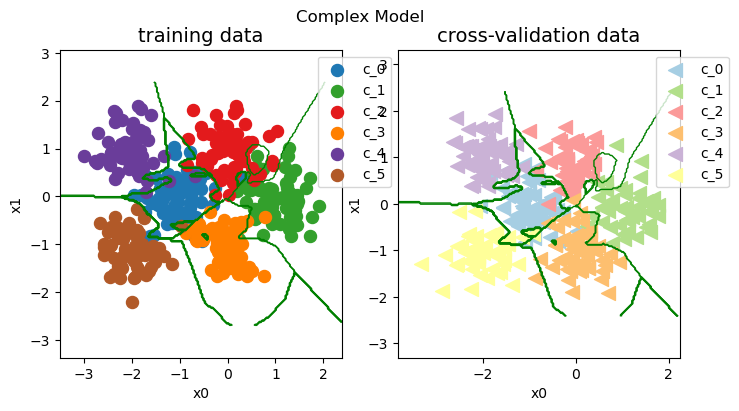

In [41]:
#make a model for plotting routines to call
model_predict = lambda X1: np.argmax(tf.nn.softmax(model_c.predict(X1)).numpy(), axis=1)
plt_nn(model_predict, X_train, y_train, classes, X_cv, y_cv, suptitle="Complex Model")

    This model has worked very hard to capture outliers of each category. As a result, it has miscategorized some of the cross-validation data. Let's calculate the classification error.

In [42]:
training_cerr_complex = eval_cat_err(y_train, model_predict(X_train))
cv_cerr_complex = eval_cat_err(y_cv, model_predict(X_cv))
print(f"categorization error, training, complex model: {training_cerr_complex:0.3f}")
print(f"categorization error, cv, complex model: {cv_cerr_complex:0.3f}")

10/10 [==============================] - 0s 1ms/step
categorization error, training, complex model: 0.020
categorization error, cv, complex model: 0.087


#### 5.1 Simple model
    Now, let's try a simple model


#### Exercise 4
    Below, compose a two-layer model:

        Dense layer with 6 units, relu activation
        Dense layer with 6 units and a linear activation.
        Compile using

            loss with SparseCategoricalCrossentropy, remember to use from_logits=True
            Adam optimizer with learning rate of 0.01.

In [11]:
tf.random.set_seed(1234)
model_s = Sequential([
        Dense(6, activation = 'relu', name="L1"),
        Dense(classes, activation = 'linear', name="L2")
    ], name = "Simple")
model_s.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.01))

model_s.fit(X_train, y_train, epochs=1000)

Epoch 1/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.8136
Epoch 2/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.5020
Epoch 3/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.2985
Epoch 4/1000
13/13 [==============================] - 0s 584us/step - loss: 1.1208
Epoch 5/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.9678
Epoch 6/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.8297
Epoch 7/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.7204
Epoch 8/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6244
Epoch 9/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5468
Epoch 10/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4797
Epoch 11/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4266
Epoch 12/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3847
Epoch 13/1000
13/13 [==

13/13 [==============================] - 0s 1ms/step - loss: 0.1999
Epoch 101/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1997
Epoch 102/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2002
Epoch 103/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2010
Epoch 104/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1975
Epoch 105/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1958
Epoch 106/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1966
Epoch 107/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1954
Epoch 108/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1958
Epoch 109/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1976
Epoch 110/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1971
Epoch 111/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1958
Epoch 112/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1932
Epoch 199/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1955
Epoch 200/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1920
Epoch 201/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1916
Epoch 202/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1903
Epoch 203/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1911
Epoch 204/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1921
Epoch 205/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1899
Epoch 206/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1936
Epoch 207/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1896
Epoch 208/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1949
Epoch 209/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1904
Epoch 210/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.1887
Epoch 297/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1930
Epoch 298/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1908
Epoch 299/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1895
Epoch 300/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1907
Epoch 301/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1899
Epoch 302/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1942
Epoch 303/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1887
Epoch 304/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1953
Epoch 305/1000
13/13 [==============================] - 0s 760us/step - loss: 0.1904
Epoch 306/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1893
Epoch 307/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1897
Epoch 308/1000
13

13/13 [==============================] - 0s 2ms/step - loss: 0.1869
Epoch 395/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1866
Epoch 396/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1913
Epoch 397/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1917
Epoch 398/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1885
Epoch 399/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1885
Epoch 400/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1900
Epoch 401/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1877
Epoch 402/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1893
Epoch 403/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1868
Epoch 404/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1886
Epoch 405/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1859
Epoch 406/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.1876
Epoch 493/1000
13/13 [==============================] - 0s 930us/step - loss: 0.1889
Epoch 494/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1866
Epoch 495/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1866
Epoch 496/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1908
Epoch 497/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1872
Epoch 498/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1871
Epoch 499/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1874
Epoch 500/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1860
Epoch 501/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1909
Epoch 502/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1880
Epoch 503/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1890
Epoch 504/1000
13

13/13 [==============================] - 0s 1ms/step - loss: 0.1894
Epoch 591/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1882
Epoch 592/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1881
Epoch 593/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1875
Epoch 594/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1866
Epoch 595/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1890
Epoch 596/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1866
Epoch 597/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1877
Epoch 598/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1859
Epoch 599/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1848
Epoch 600/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1882
Epoch 601/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1858
Epoch 602/1000
13/1

13/13 [==============================] - 0s 11ms/step - loss: 0.1873
Epoch 689/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1864
Epoch 690/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1856
Epoch 691/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1874
Epoch 692/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1862
Epoch 693/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1869
Epoch 694/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1857
Epoch 695/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1853
Epoch 696/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1842
Epoch 697/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1870
Epoch 698/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1857
Epoch 699/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1863
Epoch 700/1000
13/

13/13 [==============================] - 0s 2ms/step - loss: 0.1881
Epoch 787/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1878
Epoch 788/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1837
Epoch 789/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1861
Epoch 790/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1885
Epoch 791/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1842
Epoch 792/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1854
Epoch 793/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1874
Epoch 794/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1899
Epoch 795/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1844
Epoch 796/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1893
Epoch 797/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1849
Epoch 798/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.1858
Epoch 885/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1857
Epoch 886/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1858
Epoch 887/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1877
Epoch 888/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1865
Epoch 889/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1856
Epoch 890/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1870
Epoch 891/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1866
Epoch 892/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1860
Epoch 893/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1859
Epoch 894/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1868
Epoch 895/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1868
Epoch 896/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.1859
Epoch 983/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1861
Epoch 984/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1846
Epoch 985/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1842
Epoch 986/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1867
Epoch 987/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1842
Epoch 988/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1862
Epoch 989/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1861
Epoch 990/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1844
Epoch 991/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1859
Epoch 992/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1855
Epoch 993/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1848
Epoch 994/1000
13/1

1000/1000 [==============================] - 1s 844us/step


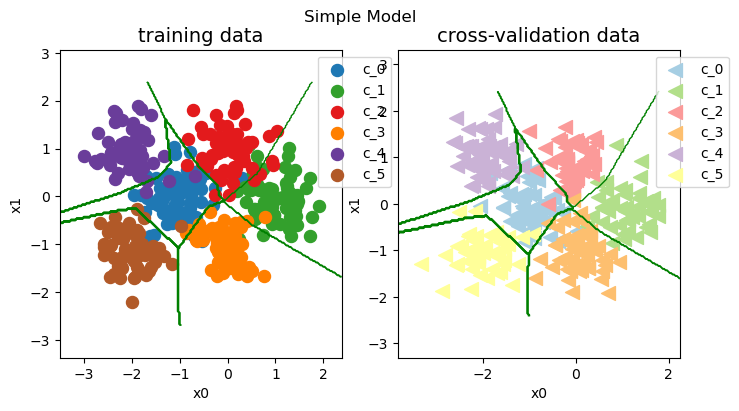

In [12]:
#make a model for plotting routines to call
model_predict_s = lambda Xl: np.argmax(tf.nn.softmax(model_s.predict(Xl)).numpy(), axis=1)
plt_nn(model_predict_s, X_train, y_train, classes, X_cv, y_cv, suptitle="Simple Model")

In [11]:
#This simple models does pretty well. Let's calculate the classification error.

training_cerr_simple = eval_cat_err(y_train, model_predict_s(X_train))
cv_cerr_simple = eval_cat_err(y_cv, model_predict_s(X_cv))
training_cerr_complex = 0.027
cv_cerr_complex = 0.087
print(f"categorization error, training, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv, simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

10/10 [==============================] - 0s 1ms/step
categorization error, training, simple model, 0.072, complex model: 0.027
categorization error, cv, simple model, 0.072, complex model: 0.087


    Our simple model has a little higher classification error on training data but does better on cross-validation data than the more complex model.
    
#### 6 - Regularization
    As in the case of polynomial regression, one can apply regularization to moderate the impact of a more complex model. Let's try this below.


##### Exercise 5
    Reconstruct your complex model, but this time include regularization. Below, compose a three-layer model:

            Dense layer with 120 units, relu activation, kernel_regularizer=tf.keras.regularizers.l2(0.1)
            Dense layer with 40 units, relu activation, kernel_regularizer=tf.keras.regularizers.l2(0.1)
            Dense layer with 6 units and a linear activation.
            Compile using

            loss with SparseCategoricalCrossentropy, remember to use from_logits=True
            Adam optimizer with learning rate of 0.01.

In [7]:
tf.random.set_seed(1234)
model_c_r = Sequential([
    Dense(120, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L1"),
    Dense(40, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L2"),
    Dense(classes, activation="linear", name="L3") #mind we are not regularixing the output layer
], name="complex_regularized")
model_c_r.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer=Adam(learning_rate=0.01))
model_c_r.fit(X_train, y_train, epochs=1000)

Epoch 1/1000
13/13 [==============================] - 0s 1ms/step - loss: 4.4158
Epoch 2/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.6526
Epoch 3/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.2943
Epoch 4/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.0666
Epoch 5/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.9934
Epoch 6/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.9703
Epoch 7/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.9170
Epoch 8/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.8889
Epoch 9/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.8197
Epoch 10/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.7711
Epoch 11/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.7625
Epoch 12/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.7648
Epoch 13/1000
13/13 [====

13/13 [==============================] - 0s 1ms/step - loss: 0.4952
Epoch 101/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4829
Epoch 102/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4728
Epoch 103/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4714
Epoch 104/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4626
Epoch 105/1000
13/13 [==============================] - 0s 880us/step - loss: 0.5091
Epoch 106/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4661
Epoch 107/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4606
Epoch 108/1000
13/13 [==============================] - 0s 876us/step - loss: 0.4711
Epoch 109/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4612
Epoch 110/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4553
Epoch 111/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4576
Epoch 112/1000


13/13 [==============================] - 0s 1ms/step - loss: 0.4003
Epoch 199/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4118
Epoch 200/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4090
Epoch 201/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4322
Epoch 202/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3995
Epoch 203/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4030
Epoch 204/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4127
Epoch 205/1000
13/13 [==============================] - 0s 983us/step - loss: 0.4628
Epoch 206/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4372
Epoch 207/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4153
Epoch 208/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4232
Epoch 209/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4432
Epoch 210/1000
13

13/13 [==============================] - 0s 1ms/step - loss: 0.3810
Epoch 297/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3880
Epoch 298/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3931
Epoch 299/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3959
Epoch 300/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4298
Epoch 301/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3954
Epoch 302/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3944
Epoch 303/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3906
Epoch 304/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3834
Epoch 305/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3847
Epoch 306/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3907
Epoch 307/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3968
Epoch 308/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3658
Epoch 395/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3963
Epoch 396/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3831
Epoch 397/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3949
Epoch 398/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3802
Epoch 399/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3763
Epoch 400/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3744
Epoch 401/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3609
Epoch 402/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3640
Epoch 403/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3638
Epoch 404/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3649
Epoch 405/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3573
Epoch 406/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3706
Epoch 493/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3541
Epoch 494/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3567
Epoch 495/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3541
Epoch 496/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3743
Epoch 497/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3991
Epoch 498/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3512
Epoch 499/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3464
Epoch 500/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3625
Epoch 501/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3562
Epoch 502/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3621
Epoch 503/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3820
Epoch 504/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3389
Epoch 591/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3495
Epoch 592/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3473
Epoch 593/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3448
Epoch 594/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3430
Epoch 595/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4260
Epoch 596/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4047
Epoch 597/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3616
Epoch 598/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3499
Epoch 599/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3443
Epoch 600/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3612
Epoch 601/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3393
Epoch 602/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3329
Epoch 689/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4055
Epoch 690/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3740
Epoch 691/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3542
Epoch 692/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3566
Epoch 693/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3471
Epoch 694/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3482
Epoch 695/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3397
Epoch 696/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3366
Epoch 697/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3358
Epoch 698/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3499
Epoch 699/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3451
Epoch 700/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3388
Epoch 787/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3373
Epoch 788/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3323
Epoch 789/1000
13/13 [==============================] - 0s 868us/step - loss: 0.3420
Epoch 790/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3369
Epoch 791/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3755
Epoch 792/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3781
Epoch 793/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3564
Epoch 794/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3574
Epoch 795/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3554
Epoch 796/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3770
Epoch 797/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3284
Epoch 798/1000
13

13/13 [==============================] - 0s 1ms/step - loss: 0.3537
Epoch 885/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3656
Epoch 886/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3560
Epoch 887/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3372
Epoch 888/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3466
Epoch 889/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3421
Epoch 890/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3622
Epoch 891/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3342
Epoch 892/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3392
Epoch 893/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3359
Epoch 894/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3476
Epoch 895/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3916
Epoch 896/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3302
Epoch 983/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3190
Epoch 984/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3360
Epoch 985/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3496
Epoch 986/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3506
Epoch 987/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3431
Epoch 988/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3212
Epoch 989/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3351
Epoch 990/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3455
Epoch 991/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3442
Epoch 992/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3560
Epoch 993/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3287
Epoch 994/1000
13/1

1000/1000 [==============================] - 1s 908us/step


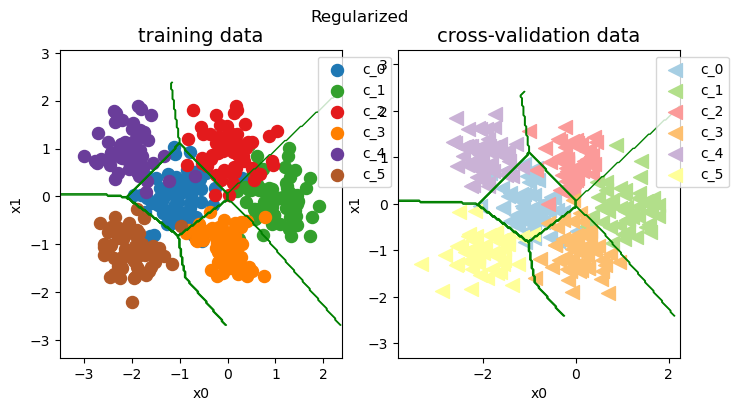

In [8]:
#make a model for plotting routines to call
model_predict_r = lambda Xl: np.argmax(tf.nn.softmax(model_c_r.predict(Xl)).numpy(), axis=1)
plt_nn(model_predict_r, X_train, y_train, classes, X_cv, y_cv, suptitle="Regularized")

In [10]:
#The results look very similar to the 'ideal' model. Let's check classification error.

training_cerr_reg = eval_cat_err(y_train, model_predict_r(X_train))
cv_cerr_reg = eval_cat_err(y_cv, model_predict_r(X_cv))
test_cerr_reg = eval_cat_err(y_test, model_predict_r(X_test))
training_cerr_complex = 0.027
cv_cerr_complex = 0.087
training_cerr_simple = 0.072
cv_cerr_simple = 0.072
print(f"categorization error, training, regularized: {training_cerr_reg:0.3f}, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv, regularized: {cv_cerr_reg:0.3f}, simple model, {cv_cerr_simple:0.3f}, complex model:  {cv_cerr_complex:0.3f}" )

3/3 [==============================] - 0s 1ms/step
categorization error, training, regularized: 0.070, simple model, 0.072, complex model: 0.027
categorization error, cv, regularized: 0.066, simple model, 0.072, complex model:  0.087


    The simple model is a bit better in the training set than the regularized model but worse in the cross validation set.
    
#### 7 - Iterate to find optimal regularization value
    As you did in linear regression, you can try many regularization values. This code takes several minutes to run. If you have time, you can run it and check the results.

In [19]:
tf.random.set_seed(1234)
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
models=[None] * len(lambdas)

for i in range(len(lambdas)):
    lambda_ = lambdas[i]
    models[i] =  Sequential(
        [
            Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(classes, activation = 'linear')
        ]
    )
    models[i].compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(0.01),
    )

    models[i].fit(
        X_train, y_train,
        epochs=1000
    )
    print(f"Finished lambda = {lambda_}")

Epoch 1/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.0572
Epoch 2/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4159
Epoch 3/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3128
Epoch 4/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2628
Epoch 5/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2700
Epoch 6/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2912
Epoch 7/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2524
Epoch 8/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2273
Epoch 9/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2313
Epoch 10/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2010
Epoch 11/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2175
Epoch 12/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2045
Epoch 13/1000
13/13 [====

Epoch 101/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1554
Epoch 102/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1566
Epoch 103/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1806
Epoch 104/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1460
Epoch 105/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1408
Epoch 106/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1402
Epoch 107/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1385
Epoch 108/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1343
Epoch 109/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1315
Epoch 110/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1309
Epoch 111/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1408
Epoch 112/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1376
Epoc

13/13 [==============================] - 0s 3ms/step - loss: 0.0955
Epoch 200/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0990
Epoch 201/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0914
Epoch 202/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0867
Epoch 203/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0779
Epoch 204/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1015
Epoch 205/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0952
Epoch 206/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1121
Epoch 207/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1272
Epoch 208/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1226
Epoch 209/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1137
Epoch 210/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1332
Epoch 211/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0705
Epoch 298/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0591
Epoch 299/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0589
Epoch 300/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0624
Epoch 301/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0565
Epoch 302/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0709
Epoch 303/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0940
Epoch 304/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0906
Epoch 305/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0908
Epoch 306/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0802
Epoch 307/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0767
Epoch 308/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1059
Epoch 309/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.1224
Epoch 396/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0971
Epoch 397/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0734
Epoch 398/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0521
Epoch 399/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0581
Epoch 400/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0468
Epoch 401/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0541
Epoch 402/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0470
Epoch 403/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0417
Epoch 404/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0419
Epoch 405/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0368
Epoch 406/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0384
Epoch 407/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0344
Epoch 494/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0335
Epoch 495/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0316
Epoch 496/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0315
Epoch 497/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0342
Epoch 498/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0331
Epoch 499/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0344
Epoch 500/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0344
Epoch 501/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0368
Epoch 502/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0401
Epoch 503/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0505
Epoch 504/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1576
Epoch 505/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0519
Epoch 592/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1219
Epoch 593/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2474
Epoch 594/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1605
Epoch 595/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2648
Epoch 596/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3348
Epoch 597/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3403
Epoch 598/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2532
Epoch 599/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1913
Epoch 600/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1338
Epoch 601/1000
13/13 [==============================] - 0s 762us/step - loss: 0.0907
Epoch 602/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0978
Epoch 603/1000
13

13/13 [==============================] - 0s 2ms/step - loss: 0.0422
Epoch 690/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0419
Epoch 691/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0352
Epoch 692/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0291
Epoch 693/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0321
Epoch 694/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0351
Epoch 695/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0265
Epoch 696/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0273
Epoch 697/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0267
Epoch 698/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0258
Epoch 699/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0282
Epoch 700/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0255
Epoch 701/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0230
Epoch 788/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0242
Epoch 789/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0218
Epoch 790/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0235
Epoch 791/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0214
Epoch 792/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0236
Epoch 793/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0228
Epoch 794/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0284
Epoch 795/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0196
Epoch 796/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0216
Epoch 797/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0206
Epoch 798/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0201
Epoch 799/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0241
Epoch 886/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0230
Epoch 887/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0225
Epoch 888/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0205
Epoch 889/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0229
Epoch 890/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0208
Epoch 891/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0197
Epoch 892/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0204
Epoch 893/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0198
Epoch 894/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0198
Epoch 895/1000
13/13 [==============================] - 0s 625us/step - loss: 0.0181
Epoch 896/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0199
Epoch 897/1000
13

13/13 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 984/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 985/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0178
Epoch 986/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0193
Epoch 987/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0182
Epoch 988/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0195
Epoch 989/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 990/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0190
Epoch 991/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0234
Epoch 992/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0236
Epoch 993/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0190
Epoch 994/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0162
Epoch 995/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.2443
Epoch 83/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2293
Epoch 84/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2354
Epoch 85/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2477
Epoch 86/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2257
Epoch 87/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2276
Epoch 88/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2366
Epoch 89/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2297
Epoch 90/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2234
Epoch 91/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2264
Epoch 92/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2218
Epoch 93/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2271
Epoch 94/1000
13/13 [=========

13/13 [==============================] - 0s 1ms/step - loss: 0.2217
Epoch 182/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2132
Epoch 183/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2074
Epoch 184/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2115
Epoch 185/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2093
Epoch 186/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1989
Epoch 187/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2018
Epoch 188/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2046
Epoch 189/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2059
Epoch 190/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2119
Epoch 191/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2176
Epoch 192/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2038
Epoch 193/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.1992
Epoch 280/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1966
Epoch 281/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1930
Epoch 282/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1929
Epoch 283/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2003
Epoch 284/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1868
Epoch 285/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1824
Epoch 286/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1951
Epoch 287/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1942
Epoch 288/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2156
Epoch 289/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1977
Epoch 290/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1996
Epoch 291/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.1787
Epoch 378/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1813
Epoch 379/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1854
Epoch 380/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1804
Epoch 381/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1841
Epoch 382/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1862
Epoch 383/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1948
Epoch 384/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1847
Epoch 385/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1807
Epoch 386/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1814
Epoch 387/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1775
Epoch 388/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1820
Epoch 389/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1952
Epoch 476/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1803
Epoch 477/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1955
Epoch 478/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1939
Epoch 479/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1837
Epoch 480/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1782
Epoch 481/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1762
Epoch 482/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1770
Epoch 483/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1901
Epoch 484/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1918
Epoch 485/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1810
Epoch 486/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1742
Epoch 487/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.1725
Epoch 574/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1717
Epoch 575/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1711
Epoch 576/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1677
Epoch 577/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1696
Epoch 578/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1760
Epoch 579/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1625
Epoch 580/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1760
Epoch 581/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1697
Epoch 582/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1611
Epoch 583/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1655
Epoch 584/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1708
Epoch 585/1000
13/1

13/13 [==============================] - 0s 889us/step - loss: 0.1648
Epoch 672/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1668
Epoch 673/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1634
Epoch 674/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1785
Epoch 675/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1772
Epoch 676/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1693
Epoch 677/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1745
Epoch 678/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1747
Epoch 679/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1781
Epoch 680/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1802
Epoch 681/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1789
Epoch 682/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1738
Epoch 683/1000
13

13/13 [==============================] - 0s 3ms/step - loss: 0.1542
Epoch 770/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1546
Epoch 771/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1567
Epoch 772/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1539
Epoch 773/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1631
Epoch 774/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1746
Epoch 775/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1674
Epoch 776/1000
13/13 [==============================] - 0s 661us/step - loss: 0.1505
Epoch 777/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1606
Epoch 778/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1594
Epoch 779/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1596
Epoch 780/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1611
Epoch 781/1000
13

13/13 [==============================] - 0s 831us/step - loss: 0.1556
Epoch 868/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1576
Epoch 869/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1523
Epoch 870/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1624
Epoch 871/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1581
Epoch 872/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1470
Epoch 873/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1546
Epoch 874/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1464
Epoch 875/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1565
Epoch 876/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1545
Epoch 877/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1520
Epoch 878/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1512
Epoch 879/1000
13

13/13 [==============================] - 0s 1ms/step - loss: 0.1626
Epoch 966/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1631
Epoch 967/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1832
Epoch 968/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1994
Epoch 969/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1704
Epoch 970/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1702
Epoch 971/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1532
Epoch 972/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1527
Epoch 973/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1538
Epoch 974/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1509
Epoch 975/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1475
Epoch 976/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1440
Epoch 977/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3627
Epoch 65/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3887
Epoch 66/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3486
Epoch 67/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3617
Epoch 68/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3507
Epoch 69/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3244
Epoch 70/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3133
Epoch 71/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3170
Epoch 72/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3000
Epoch 73/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3090
Epoch 74/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3081
Epoch 75/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3239
Epoch 76/1000
13/13 [=========

13/13 [==============================] - 0s 2ms/step - loss: 0.2753
Epoch 164/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2843
Epoch 165/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2877
Epoch 166/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2784
Epoch 167/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2789
Epoch 168/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2746
Epoch 169/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2839
Epoch 170/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2831
Epoch 171/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2627
Epoch 172/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2557
Epoch 173/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2773
Epoch 174/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2852
Epoch 175/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.2772
Epoch 262/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2550
Epoch 263/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2565
Epoch 264/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2481
Epoch 265/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2629
Epoch 266/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2558
Epoch 267/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2590
Epoch 268/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2503
Epoch 269/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2472
Epoch 270/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2570
Epoch 271/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2493
Epoch 272/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2549
Epoch 273/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.2426
Epoch 360/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2677
Epoch 361/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2546
Epoch 362/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2881
Epoch 363/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2814
Epoch 364/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2631
Epoch 365/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2503
Epoch 366/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2477
Epoch 367/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2683
Epoch 368/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2675
Epoch 369/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2500
Epoch 370/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2469
Epoch 371/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.2269
Epoch 458/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2502
Epoch 459/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2387
Epoch 460/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2410
Epoch 461/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2618
Epoch 462/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2390
Epoch 463/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2351
Epoch 464/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2383
Epoch 465/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2462
Epoch 466/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2505
Epoch 467/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2467
Epoch 468/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2469
Epoch 469/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.2394
Epoch 556/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2262
Epoch 557/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2305
Epoch 558/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2417
Epoch 559/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2592
Epoch 560/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2547
Epoch 561/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2398
Epoch 562/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2513
Epoch 563/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2292
Epoch 564/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2390
Epoch 565/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2321
Epoch 566/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2353
Epoch 567/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.2229
Epoch 654/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2446
Epoch 655/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2296
Epoch 656/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2267
Epoch 657/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2296
Epoch 658/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2294
Epoch 659/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2263
Epoch 660/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2380
Epoch 661/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2258
Epoch 662/1000
13/13 [==============================] - 0s 894us/step - loss: 0.2336
Epoch 663/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2333
Epoch 664/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2595
Epoch 665/1000
13

13/13 [==============================] - 0s 1ms/step - loss: 0.2319
Epoch 752/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2358
Epoch 753/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2205
Epoch 754/1000
13/13 [==============================] - 0s 925us/step - loss: 0.2387
Epoch 755/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2300
Epoch 756/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2292
Epoch 757/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2337
Epoch 758/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2258
Epoch 759/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2262
Epoch 760/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2371
Epoch 761/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2422
Epoch 762/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2354
Epoch 763/1000
13

13/13 [==============================] - 0s 2ms/step - loss: 0.2272
Epoch 850/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2214
Epoch 851/1000
13/13 [==============================] - 0s 746us/step - loss: 0.2266
Epoch 852/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2434
Epoch 853/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2224
Epoch 854/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2286
Epoch 855/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2323
Epoch 856/1000
13/13 [==============================] - 0s 718us/step - loss: 0.2246
Epoch 857/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2298
Epoch 858/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2277
Epoch 859/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2388
Epoch 860/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2263
Epoch 861/1000


13/13 [==============================] - 0s 1ms/step - loss: 0.2308
Epoch 948/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2360
Epoch 949/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2161
Epoch 950/1000
13/13 [==============================] - 0s 546us/step - loss: 0.2190
Epoch 951/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2183
Epoch 952/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2368
Epoch 953/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2273
Epoch 954/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2322
Epoch 955/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2175
Epoch 956/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2267
Epoch 957/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2312
Epoch 958/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2432
Epoch 959/1000
13

13/13 [==============================] - 0s 823us/step - loss: 0.4607
Epoch 47/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4297
Epoch 48/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4768
Epoch 49/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4776
Epoch 50/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4432
Epoch 51/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4504
Epoch 52/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4347
Epoch 53/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4491
Epoch 54/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4278
Epoch 55/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4546
Epoch 56/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4222
Epoch 57/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4393
Epoch 58/1000
13/13 [=======

13/13 [==============================] - 0s 1ms/step - loss: 0.3562
Epoch 146/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3556
Epoch 147/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3871
Epoch 148/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3688
Epoch 149/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3578
Epoch 150/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3549
Epoch 151/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3540
Epoch 152/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3506
Epoch 153/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3760
Epoch 154/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3558
Epoch 155/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3560
Epoch 156/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3592
Epoch 157/1000
13/1

13/13 [==============================] - 0s 809us/step - loss: 0.3340
Epoch 244/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3482
Epoch 245/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3454
Epoch 246/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3461
Epoch 247/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3284
Epoch 248/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3359
Epoch 249/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3462
Epoch 250/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3393
Epoch 251/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3649
Epoch 252/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3447
Epoch 253/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3393
Epoch 254/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3571
Epoch 255/1000
13

13/13 [==============================] - 0s 1ms/step - loss: 0.3279
Epoch 342/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3252
Epoch 343/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3264
Epoch 344/1000
13/13 [==============================] - 0s 829us/step - loss: 0.3194
Epoch 345/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3152
Epoch 346/1000
13/13 [==============================] - 0s 475us/step - loss: 0.3182
Epoch 347/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3454
Epoch 348/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3734
Epoch 349/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3247
Epoch 350/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3438
Epoch 351/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3161
Epoch 352/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3461
Epoch 353/1000


13/13 [==============================] - 0s 2ms/step - loss: 0.3084
Epoch 440/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3054
Epoch 441/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3140
Epoch 442/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3284
Epoch 443/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3236
Epoch 444/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3142
Epoch 445/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3224
Epoch 446/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3155
Epoch 447/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3377
Epoch 448/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3228
Epoch 449/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3122
Epoch 450/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3080
Epoch 451/1000
13/1

In [ ]:
def plot_iterate(lambdas, models, X_train, y_train, X_cv, y_cv):
    err_train = np.zeros(len(lambdas))
    err_cv = np.zeros(len(lambdas))
    for i in range(len(models)):
        err_train[i] = eval_cat_err(y_train, np.argmax( models[i](X_train), axis=1))
        err_cv[i] = eval_cat_err(y_cv, np.argmax( models[i](X_cv), axis=1))

    fig, ax = plt.subplots(1,1,figsize=(6,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    ax.set_title("error vs regularization",fontsize = 12)
    ax.plot(lambdas, err_train, marker='o', label="train error", color = dlc["dlblue"])
    ax.plot(lambdas, err_cv,    marker='o', label="cv error",    color = dlc["dlorange"])
    ax.set_xscale('log')
    ax.set_ylim(*ax.get_ylim())
    ax.set_xlabel("Regularization (lambda)",fontsize = 14)
    ax.set_ylabel("Error",fontsize = 14)
    ax.legend()
    fig.suptitle("Tuning Regularization",fontsize = 14)
    ax.text(0.05,0.14,"Training Error\nlower than CV",fontsize=12, ha='left',transform=ax.transAxes,color = dlc["dlblue"])
    ax.text(0.95,0.14,"Similar\nTraining, CV",    fontsize=12, ha='right',transform=ax.transAxes,color = dlc["dlblue"])
    plt.show()
    
plot_iterate(lambdas, models, X_train, y_train, X_cv, y_cv)

    As regularization is increased, the performance of the model on the training and cross-validation data sets converge. For this data set and model, lambda > 0.01 seems to be a reasonable choice.
    
#### 7.1 Test
    Let's try our optimized models on the test set and compare them to 'ideal' performance.

3/3 [==============================] - 0s 1ms/step


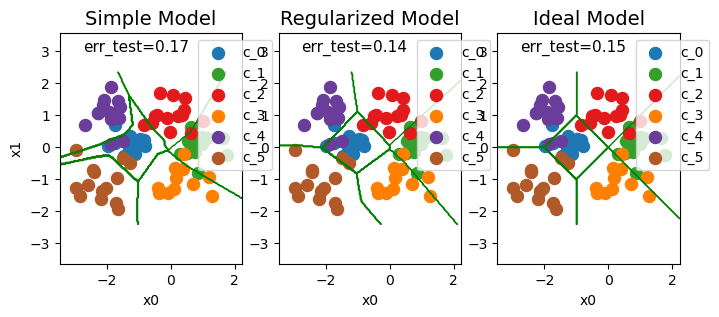

In [13]:
def plt_compare(X,y, classes, simple, regularized, centers):
    plt.close("all")
    fig,ax = plt.subplots(1,3, figsize=(8,3))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

  #plt simple   
    plot_cat_decision_boundary(ax[0], X, simple, vector=True)
    ax[0].set_title("Simple Model", fontsize=14)
    plt_mc_data(ax[0], X, y, classes, map=dkcolors_map, legend=True, size=75)
    ax[0].set_xlabel('x0'); ax[0].set_ylabel("x1");

  #plt regularized   
    plot_cat_decision_boundary(ax[1], X, regularized, vector=True)
    ax[1].set_title("Regularized Model", fontsize=14)
    plt_mc_data(ax[1], X, y, classes, map=dkcolors_map, legend=True, size=75)
    ax[1].set_xlabel('x0'); ax[0].set_ylabel("x1");

  #plt ideal
    cat_predict = lambda pt: recat(pt.reshape(1,2), centers)
    plot_cat_decision_boundary(ax[2], X, cat_predict, vector=False)
    ax[2].set_title("Ideal Model", fontsize=14)
    plt_mc_data(ax[2], X, y, classes, map=dkcolors_map, legend=True, size=75)
    ax[2].set_xlabel('x0'); ax[0].set_ylabel("x1");

    err_s = eval_cat_err(y, simple(X))
    err_r = eval_cat_err(y, regularized(X))
    ax[0].text(-2.75, 3, f"err_test={err_s:0.2f}", fontsize=11)
    ax[1].text(-2.75, 3, f"err_test={err_r:0.2f}", fontsize=11)
    
    m = len(X)
    y_eq  = np.zeros(m)
    for i in range(m):
        y_eq[i] = recat(X[i], centers)
    err_eq = eval_cat_err(y, y_eq)
    ax[2].text(-2.75, 3, f"err_test={err_eq:0.2f}", fontsize=11)
    plt.show()

plt_compare(X_test, y_test, classes, model_predict_s, model_predict_r, centers)

    Our test set is small and seems to have a number of outliers so classification error is high. However, the performance of our optimized models is comparable to ideal performance.